# VAMAE: ImageNet Transfer Baseline Experiment

This notebook implements the **ImageNet Transfer Baseline** for the VAMAE (Vessel-Aware Masked Autoencoder) project. 

## Experiment Overview

This experiment creates a supervised ImageNet-pretrained Vision Transformer (ViT) baseline adapted for single-channel OCT-Angiography images. The ImageNet-pretrained encoder serves as a comparison baseline against VAMAE's self-supervised pretraining approach.

### What This Notebook Contains:

1. **ImageNet Transfer Implementation**: Loads a ViT-Base/16 pretrained on ImageNet (supervised) and adapts it for grayscale OCT-A images
2. **Checkpoint Generation**: Saves the adapted model checkpoint for downstream tasks
3. **VAMAE Components**: Vessel-aware masking, multi-target decoder, and segmentation pipeline
4. **Evaluation Framework**: Segmentation model and training functions for comparing pretraining methods

### Key Outputs:

- **Checkpoint**: `checkpoints/imagenet_vit_base_patch16_224.pth` - ImageNet-pretrained ViT adapted for OCT-A
- **Model**: Ready-to-use encoder for vessel segmentation and disease classification tasks

### Usage:

The ImageNet checkpoint can be loaded and used as a baseline encoder in downstream segmentation/classification experiments to compare against VAMAE and other pretraining methods.

In [1]:
!pip install transformers scikit-image einops -q

zsh:1: command not found: pip


In [2]:
!pip install cv2 matplotlib skimage.filters

zsh:1: command not found: pip


In [3]:
%pip install einops scikit-image scipy


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from transformers import ViTMAEForPreTraining, ViTMAEConfig
from einops import rearrange
from skimage.filters import frangi
from skimage.morphology import skeletonize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Preprocessing

In [5]:
def compute_vesselness(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image_norm = image.astype(np.float64) / 255.0
    vesselness = frangi(image_norm, sigmas=[0.5, 1, 1.5, 2, 2.5], black_ridges=False)
    vesselness = np.clip(vesselness, 0, 1)
    
    v_min, v_max = vesselness.min(), vesselness.max()
    if v_max > v_min:
        vesselness = (vesselness - v_min) / (v_max - v_min)
    
    vesselness_uint8 = (vesselness * 255).astype(np.uint8)
    threshold_value = cv2.threshold(vesselness_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    threshold_value = int(threshold_value * 0.7)
    binary_vessels = (vesselness_uint8 > threshold_value).astype(np.uint8) * 255
    
    return binary_vessels

def compute_skeleton(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = (image > 50).astype(np.uint8)
    skeleton = skeletonize(binary).astype(np.uint8) * 255
    return skeleton

def preprocess_folder(input_dir: Path, output_dir: Path):
    output_dir.mkdir(parents=True, exist_ok=True)
    (output_dir / 'intensity').mkdir(exist_ok=True)
    (output_dir / 'vesselness').mkdir(exist_ok=True)
    (output_dir / 'skeleton').mkdir(exist_ok=True)
    
    image_files = list(input_dir.glob('*.bmp')) + list(input_dir.glob('*.png')) + list(input_dir.glob('*.jpg'))
    
    if len(image_files) == 0:
        print(f"WARNING: No images found in {input_dir}")
        return 0
    
    print(f"Processing {len(image_files)} images from {input_dir.name}...")
    
    for img_path in tqdm(image_files):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        if img.shape[0] != 256:
            img = cv2.resize(img, (256, 256))
        
        vesselness = compute_vesselness(img)
        skeleton = compute_skeleton(vesselness)
        
        base_name = img_path.stem
        cv2.imwrite(str(output_dir / 'intensity' / f"{base_name}.png"), img)
        cv2.imwrite(str(output_dir / 'vesselness' / f"{base_name}.png"), vesselness)
        cv2.imwrite(str(output_dir / 'skeleton' / f"{base_name}.png"), skeleton)
    
    return len(image_files)

In [6]:
print("="*60)
print("PREPROCESSING OCTA-500")
print("="*60)

base = Path('OCTA-500-v1')
out_base = Path('processed_data')

folders = [
    (base / 'OCTA_3mm' / 'Projection Maps' / 'OCTA(FULL)', out_base / 'processed_3mm'),
    (base / 'OCTA_6mm' / 'Projection Maps' / 'OCTA(FULL)', out_base / 'processed_6mm')
]

for input_path, output_path in folders:
    if input_path.exists():
        preprocess_folder(input_path, output_path)
        print(f"✓ Done: {output_path}")
    else:
        print(f"✗ Not found: {input_path}")

print("\nVerifying...")
for output_folder in ['processed_3mm', 'processed_6mm']:
    path = out_base / output_folder
    if path.exists():
        for subdir in ['intensity', 'vesselness', 'skeleton']:
            n = len(list((path / subdir).glob('*.png')))
            print(f"  {output_folder}/{subdir}: {n} files")

PREPROCESSING OCTA-500
Processing 200 images from OCTA(FULL)...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:16<00:00, 12.41it/s]


✓ Done: processed_data/processed_3mm
Processing 300 images from OCTA(FULL)...


100%|██████████| 300/300 [00:23<00:00, 12.97it/s]

✓ Done: processed_data/processed_6mm

Verifying...
  processed_3mm/intensity: 200 files
  processed_3mm/vesselness: 200 files
  processed_3mm/skeleton: 200 files
  processed_6mm/intensity: 300 files
  processed_6mm/vesselness: 300 files
  processed_6mm/skeleton: 300 files


In [7]:
class MultiTargetDataset(Dataset):
    def __init__(self, data_dirs: List[str], image_size: int = 224):
        self.data_dirs = [Path(d) for d in data_dirs]
        self.image_size = image_size
        self.sample_ids = []
        for data_dir in self.data_dirs:
            intensity_dir = data_dir / 'intensity'
            if intensity_dir.exists():
                for f in sorted(intensity_dir.glob('*.png')):
                    self.sample_ids.append((data_dir, f.stem))
        print(f"Loaded {len(self.sample_ids)} samples")
    
    def __len__(self):
        return len(self.sample_ids)
    
    def load_image(self, path: Path) -> torch.Tensor:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            return torch.zeros(1, self.image_size, self.image_size)
        if img.shape[0] != self.image_size:
            img = cv2.resize(img, (self.image_size, self.image_size))
        return torch.from_numpy(img).float().unsqueeze(0) / 255.0
    
    def __getitem__(self, idx: int):
        data_dir, sample_id = self.sample_ids[idx]
        return {
            'intensity': self.load_image(data_dir / 'intensity' / f"{sample_id}.png"),
            'vesselness': self.load_image(data_dir / 'vesselness' / f"{sample_id}.png"),
            'skeleton': self.load_image(data_dir / 'skeleton' / f"{sample_id}.png")
        }

class SegmentationDataset(Dataset):
    def __init__(self, data_dirs: List[str], image_size: int = 224, 
                 train_fraction: float = 1.0, split: str = 'train'):
        self.image_size = image_size
        all_samples = []
        for data_dir in [Path(d) for d in data_dirs]:
            intensity_dir = data_dir / 'intensity'
            if intensity_dir.exists():
                for f in sorted(intensity_dir.glob('*.png')):
                    all_samples.append((data_dir, f.stem))
        split_idx = int(len(all_samples) * 0.8)
        if split == 'train':
            self.samples = all_samples[:split_idx]
            if train_fraction < 1.0:
                self.samples = self.samples[:int(len(self.samples) * train_fraction)]
        else:
            self.samples = all_samples[split_idx:]
        print(f"Seg ({split}, {train_fraction*100}%): {len(self.samples)} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx: int):
        data_dir, sample_id = self.samples[idx]
        img = cv2.imread(str(data_dir / 'intensity' / f"{sample_id}.png"), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(data_dir / 'vesselness' / f"{sample_id}.png"), cv2.IMREAD_GRAYSCALE)
        if img.shape[0] != self.image_size:
            img = cv2.resize(img, (self.image_size, self.image_size))
            mask = cv2.resize(mask, (self.image_size, self.image_size))
        return {
            'image': torch.from_numpy(img).float().unsqueeze(0) / 255.0,
            'mask': torch.from_numpy(mask).float().unsqueeze(0) / 255.0
        }

## Task 3: Vessel-Aware Masking

In [8]:
class VesselAwareMasking:
    def __init__(self, image_size=224, patch_size=16, mask_ratio=0.75, strategy='hybrid', vessel_weight=0.8):
        self.image_size = image_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.strategy = strategy
        self.vessel_weight = vessel_weight
        self.num_patches = (image_size // patch_size) ** 2
    
    def compute_patch_density(self, vessel_map: torch.Tensor) -> torch.Tensor:
        patches = rearrange(vessel_map, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                          p1=self.patch_size, p2=self.patch_size)
        return patches.mean(dim=-1)
    
    def compute_skeleton_importance(self, skeleton_map: torch.Tensor) -> torch.Tensor:
        patches = rearrange(skeleton_map, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                          p1=self.patch_size, p2=self.patch_size)
        return patches.max(dim=-1)[0]
    
    def generate_mask(self, vessel_map: torch.Tensor, skeleton_map: Optional[torch.Tensor] = None) -> torch.Tensor:
        B = vessel_map.shape[0]
        device = vessel_map.device
        
        if self.strategy == 'hybrid' and skeleton_map is not None:
            density = self.compute_patch_density(vessel_map)
            importance = self.compute_skeleton_importance(skeleton_map)
            noise = torch.rand(B, self.num_patches, device=device) * (1 - self.vessel_weight)
            weights = (density * 0.5 + importance * 0.5) * self.vessel_weight + noise
        else:
            density = self.compute_patch_density(vessel_map)
            noise = torch.rand(B, self.num_patches, device=device) * (1 - self.vessel_weight)
            weights = density * self.vessel_weight + noise
        
        num_masked = int(self.num_patches * self.mask_ratio)
        _, indices = torch.topk(weights, num_masked, dim=1)
        mask = torch.zeros(B, self.num_patches, device=device, dtype=torch.bool)
        mask.scatter_(1, indices, True)
        return mask

TESTING TASK 3
Loaded 500 samples

Dataset loaded: 500 samples

Input shapes:
  Intensity: torch.Size([1, 1, 224, 224])
  Vesselness: torch.Size([1, 1, 224, 224])
  Skeleton: torch.Size([1, 1, 224, 224])

Mask output:
  Shape: torch.Size([1, 196])
  Masked patches: 147 / 196

Vessel Prioritization:
  Masked patches avg density: 0.444
  Visible patches avg density: 0.415
  Ratio: 1.07x
   PASS: Masking vessel-rich patches!


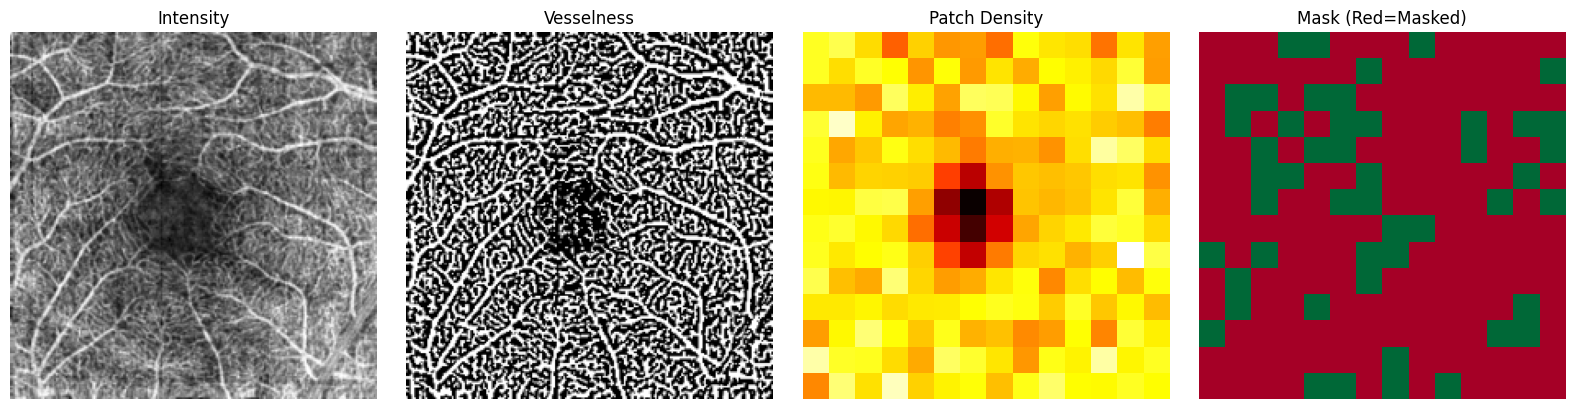

 TASK 3 TEST COMPLETE!


In [9]:
import matplotlib.pyplot as plt

print("="*60)
print("TESTING TASK 3")
print("="*60)


DATA_DIRS = ['processed_data/processed_3mm', 'processed_data/processed_6mm']
test_dataset = MultiTargetDataset(DATA_DIRS, image_size=224)

print(f"\nDataset loaded: {len(test_dataset)} samples")


sample = test_dataset[0]
intensity = sample['intensity'].unsqueeze(0).to(device)
vesselness = sample['vesselness'].unsqueeze(0).to(device)
skeleton = sample['skeleton'].unsqueeze(0).to(device)

print(f"\nInput shapes:")
print(f"  Intensity: {intensity.shape}")
print(f"  Vesselness: {vesselness.shape}")
print(f"  Skeleton: {skeleton.shape}")

vam = VesselAwareMasking(image_size=224, patch_size=16, mask_ratio=0.75, strategy='hybrid')
mask = vam.generate_mask(vesselness, skeleton)

print(f"\nMask output:")
print(f"  Shape: {mask.shape}")
print(f"  Masked patches: {mask.sum().item()} / 196")


density = vam.compute_patch_density(vesselness)
masked_density = density[0][mask[0]].mean().item()
visible_density = density[0][~mask[0]].mean().item()

print(f"\nVessel Prioritization:")
print(f"  Masked patches avg density: {masked_density:.3f}")
print(f"  Visible patches avg density: {visible_density:.3f}")
print(f"  Ratio: {masked_density/visible_density:.2f}x")

if masked_density > visible_density:
    print("   PASS: Masking vessel-rich patches!")
else:
    print("   FAIL: Not prioritizing vessels")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(intensity.squeeze().cpu(), cmap='gray')
axes[0].set_title('Intensity')
axes[0].axis('off')

axes[1].imshow(vesselness.squeeze().cpu(), cmap='gray')
axes[1].set_title('Vesselness')
axes[1].axis('off')

density_map = density.reshape(14, 14).cpu()
axes[2].imshow(density_map, cmap='hot')
axes[2].set_title('Patch Density')
axes[2].axis('off')

mask_map = mask.reshape(14, 14).float().cpu()
axes[3].imshow(mask_map, cmap='RdYlGn_r')
axes[3].set_title('Mask (Red=Masked)')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('task3_real_data_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(" TASK 3 TEST COMPLETE!")



In [10]:
class MultiTargetDecoder(nn.Module):
    def __init__(self, hidden_size=768, decoder_hidden_size=512, patch_size=16):
        super().__init__()
        self.patch_dim = patch_size * patch_size
        self.decoder_embed = nn.Linear(hidden_size, decoder_hidden_size)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_hidden_size))
        
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=decoder_hidden_size, nhead=8, dim_feedforward=decoder_hidden_size * 4, batch_first=True
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=4)
        
        self.intensity_head = nn.Linear(decoder_hidden_size, self.patch_dim)
        self.vesselness_head = nn.Linear(decoder_hidden_size, self.patch_dim)
        self.skeleton_head = nn.Linear(decoder_hidden_size, self.patch_dim)
        nn.init.normal_(self.mask_token, std=0.02)
    
    def forward(self, encoded: torch.Tensor, ids_restore: torch.Tensor):
        B, N_visible, _ = encoded.shape
        N_total = ids_restore.shape[1]
        
        x = self.decoder_embed(encoded)
        mask_tokens = self.mask_token.repeat(B, N_total - N_visible, 1)
        full_tokens = torch.cat([x, mask_tokens], dim=1)
        full_tokens = torch.gather(full_tokens, dim=1, 
                                  index=ids_restore.unsqueeze(-1).repeat(1, 1, full_tokens.shape[2]))
        
        decoded = self.decoder(full_tokens)
        
        return self.intensity_head(decoded), self.vesselness_head(decoded), self.skeleton_head(decoded)

In [11]:
class VAMAE(nn.Module):
    def __init__(self, image_size=224, patch_size=16, mask_ratio=0.75, masking_strategy='hybrid'):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        config = ViTMAEConfig(
            image_size=image_size, patch_size=patch_size, num_channels=1,
            hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
            intermediate_size=3072, mask_ratio=mask_ratio
        )
        self.encoder = ViTMAEForPreTraining(config).vit
        self.vessel_masking = VesselAwareMasking(image_size, patch_size, mask_ratio, masking_strategy)
        self.multi_decoder = MultiTargetDecoder(768, 512, patch_size)
    
    def patchify(self, imgs: torch.Tensor) -> torch.Tensor:
        p = self.patch_size
        h = w = self.image_size // p
        x = imgs.reshape(imgs.shape[0], 1, h, p, w, p)
        x = torch.einsum('nchpwq->nhwpqc', x)
        return x.reshape(imgs.shape[0], h * w, p * p)
    
    def forward(self, intensity, vesselness, skeleton):
        B = intensity.shape[0]
        device = intensity.device
        
        mask = self.vessel_masking.generate_mask(vesselness, skeleton)
        ids_shuffle = torch.argsort(mask.float(), dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        num_keep = self.num_patches - int(self.num_patches * self.vessel_masking.mask_ratio)
        ids_keep = ids_shuffle[:, :num_keep]
        
        embeddings = self.encoder.embeddings.patch_embeddings(intensity)
        embeddings = embeddings + self.encoder.embeddings.position_embeddings[:, 1:, :]
        
        embeddings_visible = torch.gather(embeddings, dim=1, 
                                         index=ids_keep.unsqueeze(-1).repeat(1, 1, embeddings.shape[2]))
        
        cls_token = self.encoder.embeddings.cls_token.expand(B, -1, -1)
        embeddings_with_cls = torch.cat([cls_token, embeddings_visible], dim=1)
        
        encoded = self.encoder.encoder(embeddings_with_cls).last_hidden_state[:, 1:, :]
        
        intensity_pred, vesselness_pred, skeleton_pred = self.multi_decoder(encoded, ids_restore)
        
        intensity_target = self.patchify(intensity)
        vesselness_target = self.patchify(vesselness)
        skeleton_target = self.patchify(skeleton)
        
        loss_intensity = F.l1_loss(intensity_pred, intensity_target, reduction='none')
        loss_vesselness = F.mse_loss(torch.sigmoid(vesselness_pred), vesselness_target, reduction='none')
        loss_skeleton = F.mse_loss(torch.sigmoid(skeleton_pred), skeleton_target, reduction='none')
        
        mask_expanded = mask.unsqueeze(-1).repeat(1, 1, loss_intensity.shape[-1])
        loss_intensity = (loss_intensity * mask_expanded).sum() / mask_expanded.sum()
        loss_vesselness = (loss_vesselness * mask_expanded).sum() / mask_expanded.sum()
        loss_skeleton = (loss_skeleton * mask_expanded).sum() / mask_expanded.sum()
        
        total_loss = loss_intensity + 0.5 * loss_vesselness + 0.5 * loss_skeleton
        
        return {'loss': total_loss, 'loss_intensity': loss_intensity, 
                'loss_vesselness': loss_vesselness, 'loss_skeleton': loss_skeleton}

TESTING TASK 4: MULTI-TARGET DECODER (REAL DATA)
Loaded 500 samples

Dataset loaded: 500 samples

Input shapes:
  Intensity: torch.Size([1, 1, 224, 224])
  Vesselness: torch.Size([1, 1, 224, 224])
  Skeleton: torch.Size([1, 1, 224, 224])

Outputs:
  Total loss: 0.8193
  Intensity loss: 0.6272
  Vesselness loss: 0.1876
  Skeleton loss: 0.1965

Reconstruction shapes:
  Intensity pred: torch.Size([1, 196, 256])
  Vesselness pred: torch.Size([1, 196, 256])
  Skeleton pred: torch.Size([1, 196, 256])

Masking:
  Masked patches: 147 / 196
  Mask ratio: 75.00%
  Expected: 75%

Reconstructed image shapes:
  Intensity: torch.Size([1, 1, 224, 224])
  Vesselness: torch.Size([1, 1, 224, 224])
  Skeleton: torch.Size([1, 1, 224, 224])


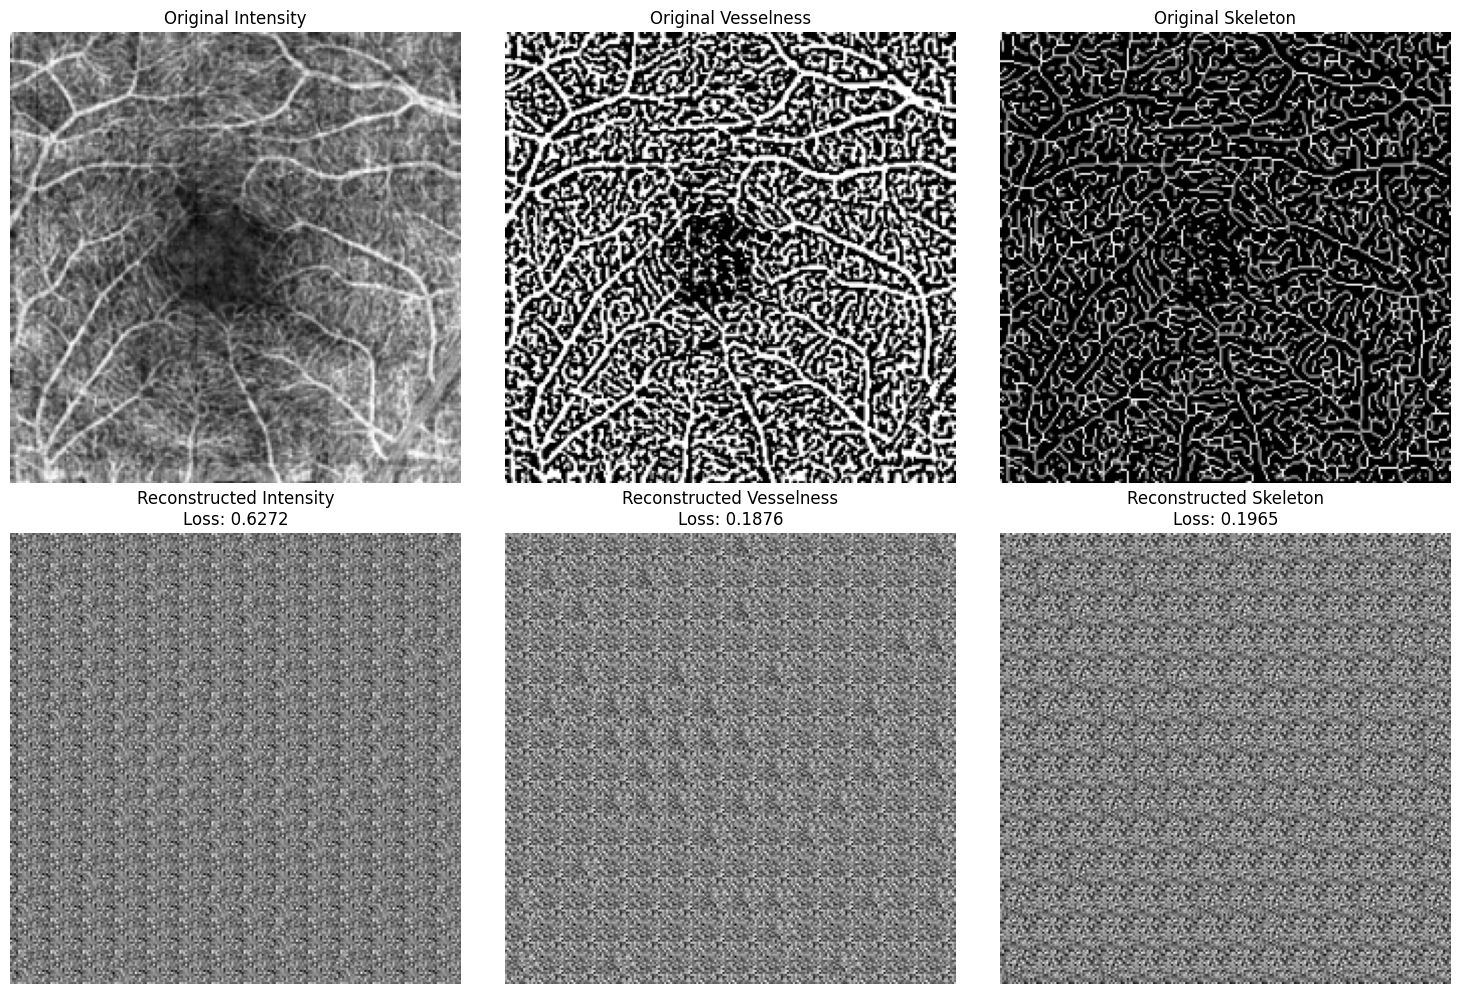


✓ PASS: Decoder producing reasonable reconstructions!

✓ TASK 4 TEST COMPLETE!

Note: Reconstructions will be poor BEFORE training.
After 50 epochs of pretraining, they should look much better!


In [12]:


import matplotlib.pyplot as plt

print("="*60)
print("TESTING TASK 4: MULTI-TARGET DECODER (REAL DATA)")
print("="*60)

# Create VAMAE model
vamae = VAMAE(image_size=224, patch_size=16, mask_ratio=0.75, masking_strategy='hybrid')
vamae = vamae.to(device)
vamae.eval()

# Load preprocessed data
DATA_DIRS = ['processed_data/processed_3mm', 'processed_data/processed_6mm']
test_dataset = MultiTargetDataset(DATA_DIRS, image_size=224)

print(f"\nDataset loaded: {len(test_dataset)} samples")

# Get first sample
sample = test_dataset[0]
intensity = sample['intensity'].unsqueeze(0).to(device)
vesselness = sample['vesselness'].unsqueeze(0).to(device)
skeleton = sample['skeleton'].unsqueeze(0).to(device)

print(f"\nInput shapes:")
print(f"  Intensity: {intensity.shape}")
print(f"  Vesselness: {vesselness.shape}")
print(f"  Skeleton: {skeleton.shape}")

# Forward pass through VAMAE
with torch.no_grad():
    outputs = vamae(intensity, vesselness, skeleton)

print(f"\nOutputs:")
print(f"  Total loss: {outputs['loss'].item():.4f}")
print(f"  Intensity loss: {outputs['loss_intensity'].item():.4f}")
print(f"  Vesselness loss: {outputs['loss_vesselness'].item():.4f}")
print(f"  Skeleton loss: {outputs['loss_skeleton'].item():.4f}")

# Get predictions by running decoder directly
with torch.no_grad():
    # Run encoder
    B = intensity.shape[0]
    device = intensity.device

    mask = vamae.vessel_masking.generate_mask(vesselness, skeleton)
    ids_shuffle = torch.argsort(mask.float(), dim=1)
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    num_keep = vamae.num_patches - int(vamae.num_patches * vamae.vessel_masking.mask_ratio)
    ids_keep = ids_shuffle[:, :num_keep]

    embeddings = vamae.encoder.embeddings.patch_embeddings(intensity)
    embeddings = embeddings + vamae.encoder.embeddings.position_embeddings[:, 1:, :]

    embeddings_visible = torch.gather(embeddings, dim=1,
                                     index=ids_keep.unsqueeze(-1).repeat(1, 1, embeddings.shape[2]))

    cls_token = vamae.encoder.embeddings.cls_token.expand(B, -1, -1)
    embeddings_with_cls = torch.cat([cls_token, embeddings_visible], dim=1)

    encoded = vamae.encoder.encoder(embeddings_with_cls).last_hidden_state[:, 1:, :]

    # Get predictions from decoder
    intensity_pred, vesselness_pred, skeleton_pred = vamae.multi_decoder(encoded, ids_restore)

print(f"\nReconstruction shapes:")
print(f"  Intensity pred: {intensity_pred.shape}")
print(f"  Vesselness pred: {vesselness_pred.shape}")
print(f"  Skeleton pred: {skeleton_pred.shape}")

# Check masking
print(f"\nMasking:")
print(f"  Masked patches: {mask.sum().item()} / 196")
print(f"  Mask ratio: {mask.float().mean().item():.2%}")
print(f"  Expected: 75%")

# Unpatchify for visualization
def unpatchify(patches, patch_size=16):
    """Convert patches back to image"""
    B, N, C = patches.shape
    h = w = int(N**0.5)
    patches = patches.reshape(B, h, w, patch_size, patch_size, 1)
    patches = patches.permute(0, 5, 1, 3, 2, 4).reshape(B, 1, h*patch_size, w*patch_size)
    return patches

# Reconstruct images
pred_intensity_img = unpatchify(intensity_pred)
pred_vesselness_img = unpatchify(torch.sigmoid(vesselness_pred))
pred_skeleton_img = unpatchify(torch.sigmoid(skeleton_pred))

print(f"\nReconstructed image shapes:")
print(f"  Intensity: {pred_intensity_img.shape}")
print(f"  Vesselness: {pred_vesselness_img.shape}")
print(f"  Skeleton: {pred_skeleton_img.shape}")

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original images (top row)
axes[0, 0].imshow(intensity.squeeze().cpu(), cmap='gray')
axes[0, 0].set_title('Original Intensity')
axes[0, 0].axis('off')

axes[0, 1].imshow(vesselness.squeeze().cpu(), cmap='gray')
axes[0, 1].set_title('Original Vesselness')
axes[0, 1].axis('off')

axes[0, 2].imshow(skeleton.squeeze().cpu(), cmap='gray')
axes[0, 2].set_title('Original Skeleton')
axes[0, 2].axis('off')

# Reconstructed images (bottom row)
axes[1, 0].imshow(pred_intensity_img.squeeze().cpu(), cmap='gray')
axes[1, 0].set_title(f'Reconstructed Intensity\nLoss: {outputs["loss_intensity"].item():.4f}')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_vesselness_img.squeeze().cpu(), cmap='gray')
axes[1, 1].set_title(f'Reconstructed Vesselness\nLoss: {outputs["loss_vesselness"].item():.4f}')
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_skeleton_img.squeeze().cpu(), cmap='gray')
axes[1, 2].set_title(f'Reconstructed Skeleton\nLoss: {outputs["loss_skeleton"].item():.4f}')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('task4_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

# Check if decoder is working
if outputs['loss'].item() < 10.0:
    print("\n✓ PASS: Decoder producing reasonable reconstructions!")
else:
    print("\n✗ WARNING: Loss is very high - decoder may need training")

print("\n✓ TASK 4 TEST COMPLETE!")
print("\nNote: Reconstructions will be poor BEFORE training.")
print("After 50 epochs of pretraining, they should look much better!")


In [13]:
class SegmentationHead(nn.Module):
    def __init__(self, in_channels=768, image_size=224, patch_size=16):
        super().__init__()
        self.grid_size = image_size // patch_size
        self.conv1 = nn.ConvTranspose2d(in_channels, 256, kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final = nn.Conv2d(32, 1, kernel_size=1)
    
    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, self.grid_size, self.grid_size, C).permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return self.final(x)

class SegmentationModel(nn.Module):
    def __init__(self, encoder, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.seg_head = SegmentationHead()
    
    def forward(self, x):
        B = x.shape[0]
        device = x.device
        
        embeddings = self.encoder.embeddings.patch_embeddings(x)
        embeddings = embeddings + self.encoder.embeddings.position_embeddings[:, 1:, :]
        
        cls_token = self.encoder.embeddings.cls_token.expand(B, -1, -1)
        encoded = self.encoder.encoder(torch.cat([cls_token, embeddings], dim=1)).last_hidden_state[:, 1:, :]
        
        return self.seg_head(encoded)

def dice_coefficient(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    
    batch_size = pred.shape[0]
    pred_flat = pred.view(batch_size, -1)
    target_flat = target.view(batch_size, -1)
    
    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)
    
    dice_scores = (2.0 * intersection / (union + 1e-8))
    
    return dice_scores.mean().item()

In [ ]:
def train_vamae(model, train_loader, epochs, lr, device):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for batch in tqdm(train_loader, desc=f"VAMAE {epoch+1}/{epochs}"):
            intensity = batch['intensity'].to(device)
            vesselness = batch['vesselness'].to(device)
            skeleton = batch['skeleton'].to(device)
            outputs = model(intensity, vesselness, skeleton)
            loss = outputs['loss']
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        scheduler.step()
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")
    return losses

def train_segmentation(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    

    for param in model.encoder.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    def dice_loss(pred, target, smooth=1.0):
        pred = torch.sigmoid(pred)
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        intersection = (pred_flat * target_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice.mean()
    
    val_dices = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Seg {epoch+1}/{epochs}"):
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            preds = model(images)
            
            bce_loss = F.binary_cross_entropy_with_logits(preds, masks)
            d_loss = dice_loss(preds, masks)
            loss = bce_loss + d_loss
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        dice_scores = []
        with torch.no_grad():
            for batch in val_loader:
                images, masks = batch['image'].to(device), batch['mask'].to(device)
                preds = model(images)
                dice_scores.append(dice_coefficient(preds, masks))
        
        avg_dice = np.mean(dice_scores)
        val_dices.append(avg_dice)
        avg_train_loss = np.mean(train_losses)
        print(f"Epoch {epoch+1}: TrainLoss={avg_train_loss:.4f}, Dice={avg_dice:.4f}")
    
    return val_dices

TESTING TASK 5: SEGMENTATION MODEL (REAL DATA)
Loaded 500 samples

Dataset loaded: 500 samples

Input:
  Image: torch.Size([1, 1, 224, 224])
  Ground truth: torch.Size([1, 1, 224, 224])

Output:
  Prediction: torch.Size([1, 1, 224, 224])
  Prediction range: [-0.143, -0.077]
  After sigmoid range: [0.464, 0.481]

Dice coefficient (BEFORE training): 0.0000
  Note: This will be LOW (~0.0-0.2) because model is untrained

Pixel statistics:
  Ground truth vessels: 21761 / 50176 (43.37%)
  Predicted vessels: 0 / 50176 (0.00%)


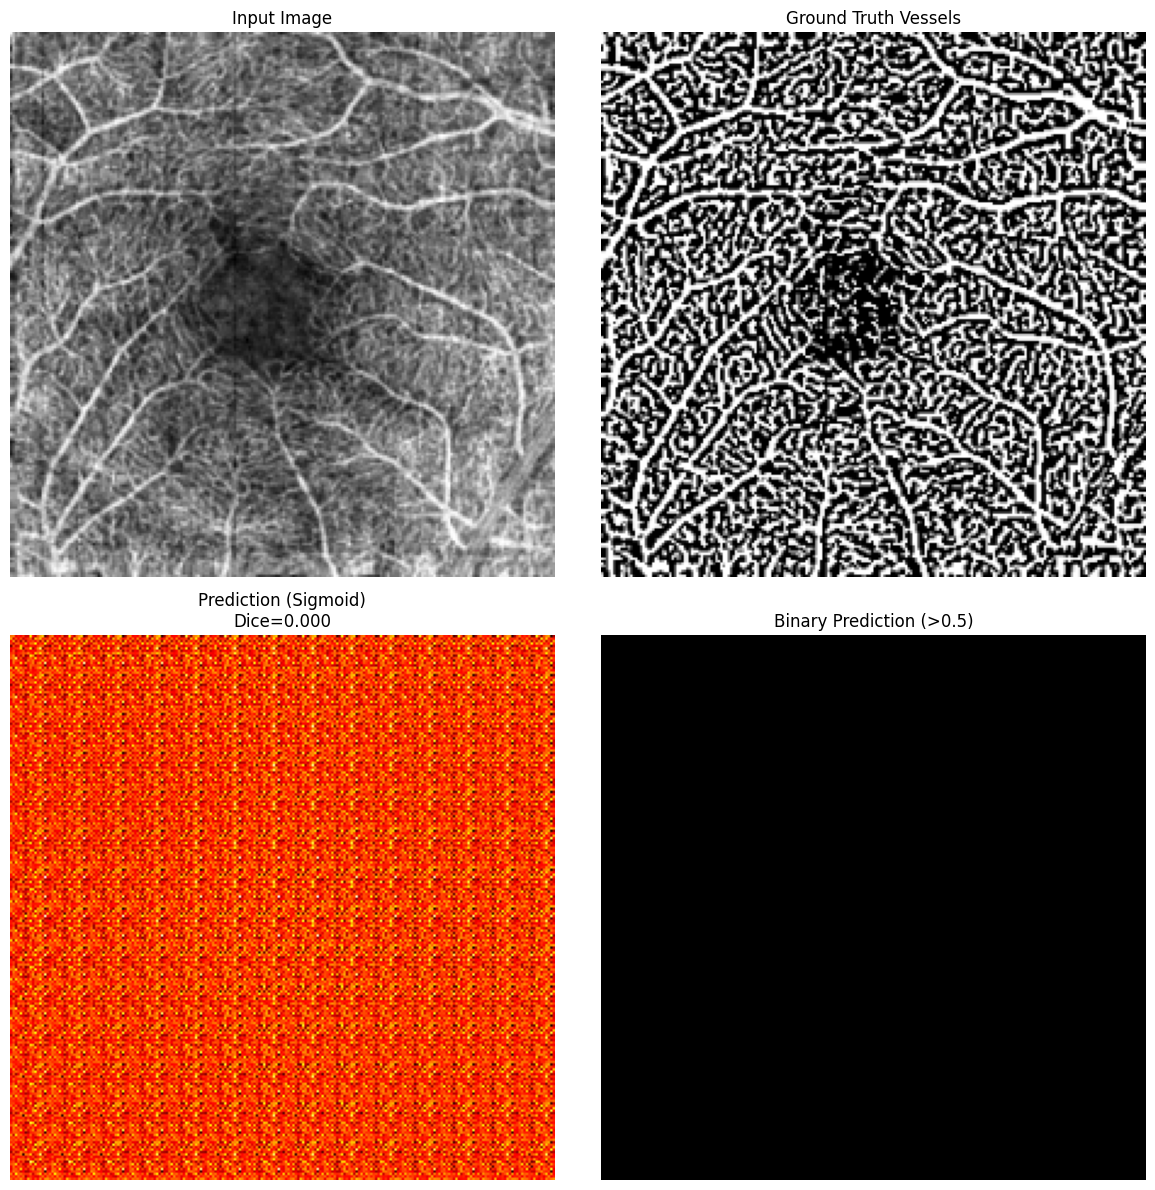


Encoder frozen: False
  Note: Set to False for fine-tuning during training

Model parameters:
  Total: 86,364,417
  Trainable: 86,213,121

✓ PASS: Model working correctly (low Dice is expected before training)

✓ TASK 5 TEST COMPLETE!

After training with labeled data, Dice should reach:
  1% labels:  ~0.60-0.70
  5% labels:  ~0.70-0.75
  100% labels: ~0.80-0.85


In [15]:


import matplotlib.pyplot as plt

print("="*60)
print("TESTING TASK 5: SEGMENTATION MODEL (REAL DATA)")
print("="*60)

# Create segmentation model using VAMAE encoder
seg_model = SegmentationModel(vamae.encoder, freeze_encoder=False)
seg_model = seg_model.to(device)
seg_model.eval()

# Load preprocessed data
DATA_DIRS = ['processed_data/processed_3mm', 'processed_data/processed_6mm']
test_dataset = MultiTargetDataset(DATA_DIRS, image_size=224)

print(f"\nDataset loaded: {len(test_dataset)} samples")

# Get first sample
sample = test_dataset[0]
intensity = sample['intensity'].unsqueeze(0).to(device)
vesselness = sample['vesselness'].unsqueeze(0).to(device)  # Use as ground truth

print(f"\nInput:")
print(f"  Image: {intensity.shape}")
print(f"  Ground truth: {vesselness.shape}")

# Forward pass
with torch.no_grad():
    pred = seg_model(intensity)

print(f"\nOutput:")
print(f"  Prediction: {pred.shape}")
print(f"  Prediction range: [{pred.min().item():.3f}, {pred.max().item():.3f}]")

# Apply sigmoid and threshold for binary prediction
pred_sigmoid = torch.sigmoid(pred)
pred_binary = (pred_sigmoid > 0.5).float()

print(f"  After sigmoid range: [{pred_sigmoid.min().item():.3f}, {pred_sigmoid.max().item():.3f}]")

# Compute Dice (before training)
dice = dice_coefficient(pred, vesselness)
print(f"\nDice coefficient (BEFORE training): {dice:.4f}")
print("  Note: This will be LOW (~0.0-0.2) because model is untrained")

# Check predictions
vessel_pixels_gt = (vesselness > 0.5).sum().item()
vessel_pixels_pred = (pred_binary > 0.5).sum().item()
total_pixels = vesselness.numel()

print(f"\nPixel statistics:")
print(f"  Ground truth vessels: {vessel_pixels_gt} / {total_pixels} ({vessel_pixels_gt/total_pixels*100:.2f}%)")
print(f"  Predicted vessels: {vessel_pixels_pred} / {total_pixels} ({vessel_pixels_pred/total_pixels*100:.2f}%)")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(intensity.squeeze().cpu(), cmap='gray')
axes[0, 0].set_title('Input Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(vesselness.squeeze().cpu(), cmap='gray')
axes[0, 1].set_title('Ground Truth Vessels')
axes[0, 1].axis('off')

axes[1, 0].imshow(pred_sigmoid.squeeze().cpu(), cmap='hot')
axes[1, 0].set_title(f'Prediction (Sigmoid)\nDice={dice:.3f}')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_binary.squeeze().cpu(), cmap='gray')
axes[1, 1].set_title('Binary Prediction (>0.5)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('task5_segmentation_before_training.png', dpi=150, bbox_inches='tight')
plt.show()

# Test encoder freezing
print(f"\nEncoder frozen: {not next(seg_model.encoder.parameters()).requires_grad}")
print("  Note: Set to False for fine-tuning during training")


total_params = sum(p.numel() for p in seg_model.parameters())
trainable_params = sum(p.numel() for p in seg_model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

if dice < 0.3:
    print("\n✓ PASS: Model working correctly (low Dice is expected before training)")
else:
    print("\n⚠ WARNING: Dice unexpectedly high for untrained model")

print("\n✓ TASK 5 TEST COMPLETE!")
print("\nAfter training with labeled data, Dice should reach:")
print("  1% labels:  ~0.60-0.70")
print("  5% labels:  ~0.70-0.75")
print("  100% labels: ~0.80-0.85")


In [16]:
DATA_DIRS = ['processed_data/processed_3mm', 'processed_data/processed_6mm']

print("Loading data...")
train_dataset = MultiTargetDataset(DATA_DIRS, image_size=224)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

print("\nTraining VAMAE...")
vamae_model = VAMAE(image_size=224, patch_size=16, mask_ratio=0.75, masking_strategy='hybrid')
vamae_losses = train_vamae(vamae_model, train_loader, epochs=1, lr=1e-4, device=device)

torch.save(vamae_model.state_dict(), 'vamae_model.pth')
print("\n✓ VAMAE complete!")

Loading data...
Loaded 500 samples

Training VAMAE...


VAMAE 1/1: 100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


Epoch 1: Loss=0.3563

✓ VAMAE complete!


In [17]:
print("\nSegmentation Evaluation")
label_fractions = [0.01, 0.05, 0.10, 0.25, 1.0]
results = []

print("\n=== DEBUGGING ===")
debug_dataset = SegmentationDataset(['processed_data/processed_3mm', 'processed_data/processed_6mm'], train_fraction=1.0, split='train')
debug_loader = DataLoader(debug_dataset, batch_size=8, shuffle=False)
debug_batch = next(iter(debug_loader))
print(f"Input image range: [{debug_batch['image'].min():.3f}, {debug_batch['image'].max():.3f}]")
print(f"Target mask range: [{debug_batch['mask'].min():.3f}, {debug_batch['mask'].max():.3f}]")
print(f"Target mask mean: {debug_batch['mask'].mean():.3f}")
print(f"Vessel pixels in mask: {(debug_batch['mask'] > 0.5).sum().item()} / {debug_batch['mask'].numel()}")
print("=================\n")

for fraction in label_fractions:
    print(f"\n{fraction*100}% labels...")
    train_seg = SegmentationDataset(['processed_data/processed_3mm', 'processed_data/processed_6mm'], train_fraction=fraction, split='train')
    val_seg = SegmentationDataset(['processed_data/processed_3mm', 'processed_data/processed_6mm'], split='val')
    train_loader = DataLoader(train_seg, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_seg, batch_size=8, shuffle=False)
    
    seg_model = SegmentationModel(vamae_model.encoder, freeze_encoder=False)
    val_dices = train_segmentation(seg_model, train_loader, val_loader, epochs=30, lr=1e-4, device=device)
    best_dice = max(val_dices)
    results.append(best_dice)
    print(f"Best Dice: {best_dice:.4f}")

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
for i, fraction in enumerate(label_fractions):
    print(f"{fraction*100:>5.1f}%: {results[i]:.4f}")

with open('vamae_results.json', 'w') as f:
    json.dump({'fractions': label_fractions, 'dice_scores': results}, f, indent=2)
print("\n✓ Done!")


Segmentation Evaluation

=== DEBUGGING ===
Seg (train, 100.0%): 400 samples
Input image range: [0.027, 1.000]
Target mask range: [0.000, 1.000]
Target mask mean: 0.425
Vessel pixels in mask: 170219 / 401408


1.0% labels...
Seg (train, 1.0%): 4 samples
Seg (val, 100.0%): 100 samples


Seg 1/30: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 1: TrainLoss=1.2279, Dice=0.5595


Seg 2/30: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch 2: TrainLoss=1.2274, Dice=0.5614


Seg 3/30: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 3: TrainLoss=1.2271, Dice=0.5631


Seg 4/30: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 4: TrainLoss=1.2268, Dice=0.5619


Seg 5/30: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 5: TrainLoss=1.2266, Dice=0.5620


Seg 6/30: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch 6: TrainLoss=1.2265, Dice=0.5604


Seg 7/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 7: TrainLoss=1.2263, Dice=0.5603


Seg 8/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 8: TrainLoss=1.2262, Dice=0.5610


Seg 9/30: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch 9: TrainLoss=1.2261, Dice=0.5612


Seg 10/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 10: TrainLoss=1.2260, Dice=0.5616


Seg 11/30: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch 11: TrainLoss=1.2259, Dice=0.5607


Seg 12/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 12: TrainLoss=1.2258, Dice=0.5610


Seg 13/30: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch 13: TrainLoss=1.2257, Dice=0.5617


Seg 14/30: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch 14: TrainLoss=1.2255, Dice=0.5620


Seg 15/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 15: TrainLoss=1.2253, Dice=0.5618


Seg 16/30: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch 16: TrainLoss=1.2250, Dice=0.5630


Seg 17/30: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch 17: TrainLoss=1.2246, Dice=0.5645


Seg 18/30: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch 18: TrainLoss=1.2240, Dice=0.5639


Seg 19/30: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 19: TrainLoss=1.2238, Dice=0.5645


Seg 20/30: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Epoch 20: TrainLoss=1.2237, Dice=0.5652


Seg 21/30: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 21: TrainLoss=1.2236, Dice=0.5648


Seg 22/30: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch 22: TrainLoss=1.2233, Dice=0.5640


Seg 23/30: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Epoch 23: TrainLoss=1.2231, Dice=0.5626


Seg 24/30: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Epoch 24: TrainLoss=1.2230, Dice=0.5615


Seg 25/30: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Epoch 25: TrainLoss=1.2229, Dice=0.5613


Seg 26/30: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Epoch 26: TrainLoss=1.2227, Dice=0.5611


Seg 27/30: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 27: TrainLoss=1.2225, Dice=0.5622


Seg 28/30: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Epoch 28: TrainLoss=1.2224, Dice=0.5621


Seg 29/30: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Epoch 29: TrainLoss=1.2222, Dice=0.5632


Seg 30/30: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Epoch 30: TrainLoss=1.2222, Dice=0.5619
Best Dice: 0.5652

5.0% labels...
Seg (train, 5.0%): 20 samples
Seg (val, 100.0%): 100 samples


Seg 1/30: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


Epoch 1: TrainLoss=1.2379, Dice=0.5671


Seg 2/30: 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


Epoch 2: TrainLoss=1.2348, Dice=0.5677


Seg 3/30: 100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


Epoch 3: TrainLoss=1.2324, Dice=0.5647


Seg 4/30: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch 4: TrainLoss=1.2324, Dice=0.5561


Seg 5/30: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch 5: TrainLoss=1.2329, Dice=0.5485


Seg 6/30: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Epoch 6: TrainLoss=1.2294, Dice=0.5590


Seg 7/30: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch 7: TrainLoss=1.2252, Dice=0.5622


Seg 8/30: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Epoch 8: TrainLoss=1.2269, Dice=0.5675


Seg 9/30: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 9: TrainLoss=1.2230, Dice=0.5682


Seg 10/30: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch 10: TrainLoss=1.2235, Dice=0.5644


Seg 11/30: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch 11: TrainLoss=1.2217, Dice=0.5680


Seg 12/30: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


Epoch 12: TrainLoss=1.2197, Dice=0.5594


Seg 13/30: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


Epoch 13: TrainLoss=1.2189, Dice=0.5664


Seg 14/30: 100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch 14: TrainLoss=1.2185, Dice=0.5481


Seg 15/30: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Epoch 15: TrainLoss=1.2182, Dice=0.5644


Seg 16/30: 100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch 16: TrainLoss=1.2179, Dice=0.5545


Seg 17/30: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


Epoch 17: TrainLoss=1.2195, Dice=0.5565


Seg 18/30: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch 18: TrainLoss=1.2176, Dice=0.5507


Seg 19/30: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch 19: TrainLoss=1.2185, Dice=0.5609


Seg 20/30: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch 20: TrainLoss=1.2181, Dice=0.5470


Seg 21/30: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 21: TrainLoss=1.2190, Dice=0.5611


Seg 22/30: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 22: TrainLoss=1.2183, Dice=0.5524


Seg 23/30: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch 23: TrainLoss=1.2183, Dice=0.5473


Seg 24/30: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 24: TrainLoss=1.2171, Dice=0.5571


Seg 25/30: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 25: TrainLoss=1.2187, Dice=0.5470


Seg 26/30: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Epoch 26: TrainLoss=1.2171, Dice=0.5542


Seg 27/30: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch 27: TrainLoss=1.2162, Dice=0.5435


Seg 28/30: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 28: TrainLoss=1.2167, Dice=0.5539


Seg 29/30: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 29: TrainLoss=1.2168, Dice=0.5476


Seg 30/30: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 30: TrainLoss=1.2166, Dice=0.5552
Best Dice: 0.5682

10.0% labels...
Seg (train, 10.0%): 40 samples
Seg (val, 100.0%): 100 samples


Seg 1/30: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 1: TrainLoss=1.2328, Dice=0.5681


Seg 2/30: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Epoch 2: TrainLoss=1.2308, Dice=0.5681


Seg 3/30: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 3: TrainLoss=1.2303, Dice=0.5681


Seg 4/30: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Epoch 4: TrainLoss=1.2300, Dice=0.5681


Seg 5/30: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 5: TrainLoss=1.2296, Dice=0.5681


Seg 6/30: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Epoch 6: TrainLoss=1.2295, Dice=0.5681


Seg 7/30: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Epoch 7: TrainLoss=1.2292, Dice=0.5679


Seg 8/30: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 8: TrainLoss=1.2287, Dice=0.5673


Seg 9/30: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Epoch 9: TrainLoss=1.2282, Dice=0.5602


Seg 10/30: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 10: TrainLoss=1.2275, Dice=0.5601


Seg 11/30: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 11: TrainLoss=1.2262, Dice=0.5497


Seg 12/30: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 12: TrainLoss=1.2238, Dice=0.5443


Seg 13/30: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 13: TrainLoss=1.2200, Dice=0.5564


Seg 14/30: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


Epoch 14: TrainLoss=1.2187, Dice=0.5377


Seg 15/30: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 15: TrainLoss=1.2187, Dice=0.5603


Seg 16/30: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 16: TrainLoss=1.2176, Dice=0.5476


Seg 17/30: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


Epoch 17: TrainLoss=1.2163, Dice=0.5504


Seg 18/30: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 18: TrainLoss=1.2154, Dice=0.5540


Seg 19/30: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 19: TrainLoss=1.2143, Dice=0.5483


Seg 20/30: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Epoch 20: TrainLoss=1.2136, Dice=0.5451


Seg 21/30: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 21: TrainLoss=1.2134, Dice=0.5474


Seg 22/30: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 22: TrainLoss=1.2128, Dice=0.5476


Seg 23/30: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 23: TrainLoss=1.2117, Dice=0.5515


Seg 24/30: 100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


Epoch 24: TrainLoss=1.2111, Dice=0.5521


Seg 25/30: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 25: TrainLoss=1.2105, Dice=0.5455


Seg 26/30: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 26: TrainLoss=1.2097, Dice=0.5432


Seg 27/30: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Epoch 27: TrainLoss=1.2083, Dice=0.5487


Seg 28/30: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 28: TrainLoss=1.2096, Dice=0.5433


Seg 29/30: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 29: TrainLoss=1.2080, Dice=0.5481


Seg 30/30: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 30: TrainLoss=1.2068, Dice=0.5446
Best Dice: 0.5681

25.0% labels...
Seg (train, 25.0%): 100 samples
Seg (val, 100.0%): 100 samples


Seg 1/30: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


Epoch 1: TrainLoss=1.2322, Dice=0.5681


Seg 2/30: 100%|██████████| 13/13 [00:24<00:00,  1.92s/it]


Epoch 2: TrainLoss=1.2279, Dice=0.5674


Seg 3/30: 100%|██████████| 13/13 [00:26<00:00,  2.04s/it]


Epoch 3: TrainLoss=1.2235, Dice=0.5478


Seg 4/30: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 4: TrainLoss=1.2167, Dice=0.5346


Seg 5/30: 100%|██████████| 13/13 [00:23<00:00,  1.85s/it]


Epoch 5: TrainLoss=1.2084, Dice=0.5365


Seg 6/30: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


Epoch 6: TrainLoss=1.2034, Dice=0.5365


Seg 7/30: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


Epoch 7: TrainLoss=1.2020, Dice=0.5500


Seg 8/30: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch 8: TrainLoss=1.1992, Dice=0.5555


Seg 9/30: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Epoch 9: TrainLoss=1.1977, Dice=0.5457


Seg 10/30: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Epoch 10: TrainLoss=1.1967, Dice=0.5114


Seg 11/30: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


Epoch 11: TrainLoss=1.1965, Dice=0.5473


Seg 12/30: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 12: TrainLoss=1.1950, Dice=0.5510


Seg 13/30: 100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


Epoch 13: TrainLoss=1.1940, Dice=0.5521


Seg 14/30: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Epoch 14: TrainLoss=1.1917, Dice=0.5418


Seg 15/30: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


Epoch 15: TrainLoss=1.1892, Dice=0.5368


Seg 16/30: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 16: TrainLoss=1.1867, Dice=0.5381


Seg 17/30: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Epoch 17: TrainLoss=1.1856, Dice=0.5304


Seg 18/30: 100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


Epoch 18: TrainLoss=1.1838, Dice=0.5414


Seg 19/30: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 19: TrainLoss=1.1808, Dice=0.5217


Seg 20/30: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 20: TrainLoss=1.1777, Dice=0.5475


Seg 21/30: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Epoch 21: TrainLoss=1.1742, Dice=0.5460


Seg 22/30: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch 22: TrainLoss=1.1701, Dice=0.5465


Seg 23/30: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Epoch 23: TrainLoss=1.1656, Dice=0.5484


Seg 24/30: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


Epoch 24: TrainLoss=1.1614, Dice=0.5349


Seg 25/30: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 25: TrainLoss=1.1562, Dice=0.5532


Seg 26/30: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


Epoch 26: TrainLoss=1.1501, Dice=0.5562


Seg 27/30: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 27: TrainLoss=1.1450, Dice=0.5608


Seg 28/30: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 28: TrainLoss=1.1385, Dice=0.5563


Seg 29/30: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


Epoch 29: TrainLoss=1.1304, Dice=0.5578


Seg 30/30: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


Epoch 30: TrainLoss=1.1229, Dice=0.5681
Best Dice: 0.5681

100.0% labels...
Seg (train, 100.0%): 400 samples
Seg (val, 100.0%): 100 samples


Seg 1/30: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch 1: TrainLoss=1.2241, Dice=0.5550


Seg 2/30: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch 2: TrainLoss=1.1569, Dice=0.5463


Seg 3/30: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Epoch 3: TrainLoss=1.1384, Dice=0.5516


Seg 4/30: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Epoch 4: TrainLoss=1.1276, Dice=0.5317


Seg 5/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 5: TrainLoss=1.1183, Dice=0.5683


Seg 6/30: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 6: TrainLoss=1.1046, Dice=0.5772


Seg 7/30: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Epoch 7: TrainLoss=1.0904, Dice=0.5755


Seg 8/30: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 8: TrainLoss=1.0762, Dice=0.5861


Seg 9/30: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 9: TrainLoss=1.0613, Dice=0.5946


Seg 10/30: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 10: TrainLoss=1.0469, Dice=0.6057


Seg 11/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 11: TrainLoss=1.0323, Dice=0.6018


Seg 12/30: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Epoch 12: TrainLoss=1.0175, Dice=0.6147


Seg 13/30: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 13: TrainLoss=1.0025, Dice=0.6229


Seg 14/30: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 14: TrainLoss=0.9866, Dice=0.6326


Seg 15/30: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 15: TrainLoss=0.9706, Dice=0.6362


Seg 16/30: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 16: TrainLoss=0.9562, Dice=0.6409


Seg 17/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 17: TrainLoss=0.9428, Dice=0.6514


Seg 18/30: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


Epoch 18: TrainLoss=0.9282, Dice=0.6548


Seg 19/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 19: TrainLoss=0.9146, Dice=0.6650


Seg 20/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 20: TrainLoss=0.8997, Dice=0.6647


Seg 21/30: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


Epoch 21: TrainLoss=0.8877, Dice=0.6732


Seg 22/30: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 22: TrainLoss=0.8750, Dice=0.6740


Seg 23/30: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 23: TrainLoss=0.8624, Dice=0.6847


Seg 24/30: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 24: TrainLoss=0.8505, Dice=0.6886


Seg 25/30: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 25: TrainLoss=0.8414, Dice=0.6924


Seg 26/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 26: TrainLoss=0.8317, Dice=0.6966


Seg 27/30: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 27: TrainLoss=0.8225, Dice=0.6985


Seg 28/30: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Epoch 28: TrainLoss=0.8122, Dice=0.7018


Seg 29/30: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 29: TrainLoss=0.8036, Dice=0.7052


Seg 30/30: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 30: TrainLoss=0.7965, Dice=0.7064
Best Dice: 0.7064

FINAL RESULTS
  1.0%: 0.5652
  5.0%: 0.5682
 10.0%: 0.5681
 25.0%: 0.5681
100.0%: 0.7064

✓ Done!


SEGMENTATION COMPARISON: BEFORE vs AFTER TRAINING
Seg (val, 100.0%): 100 samples


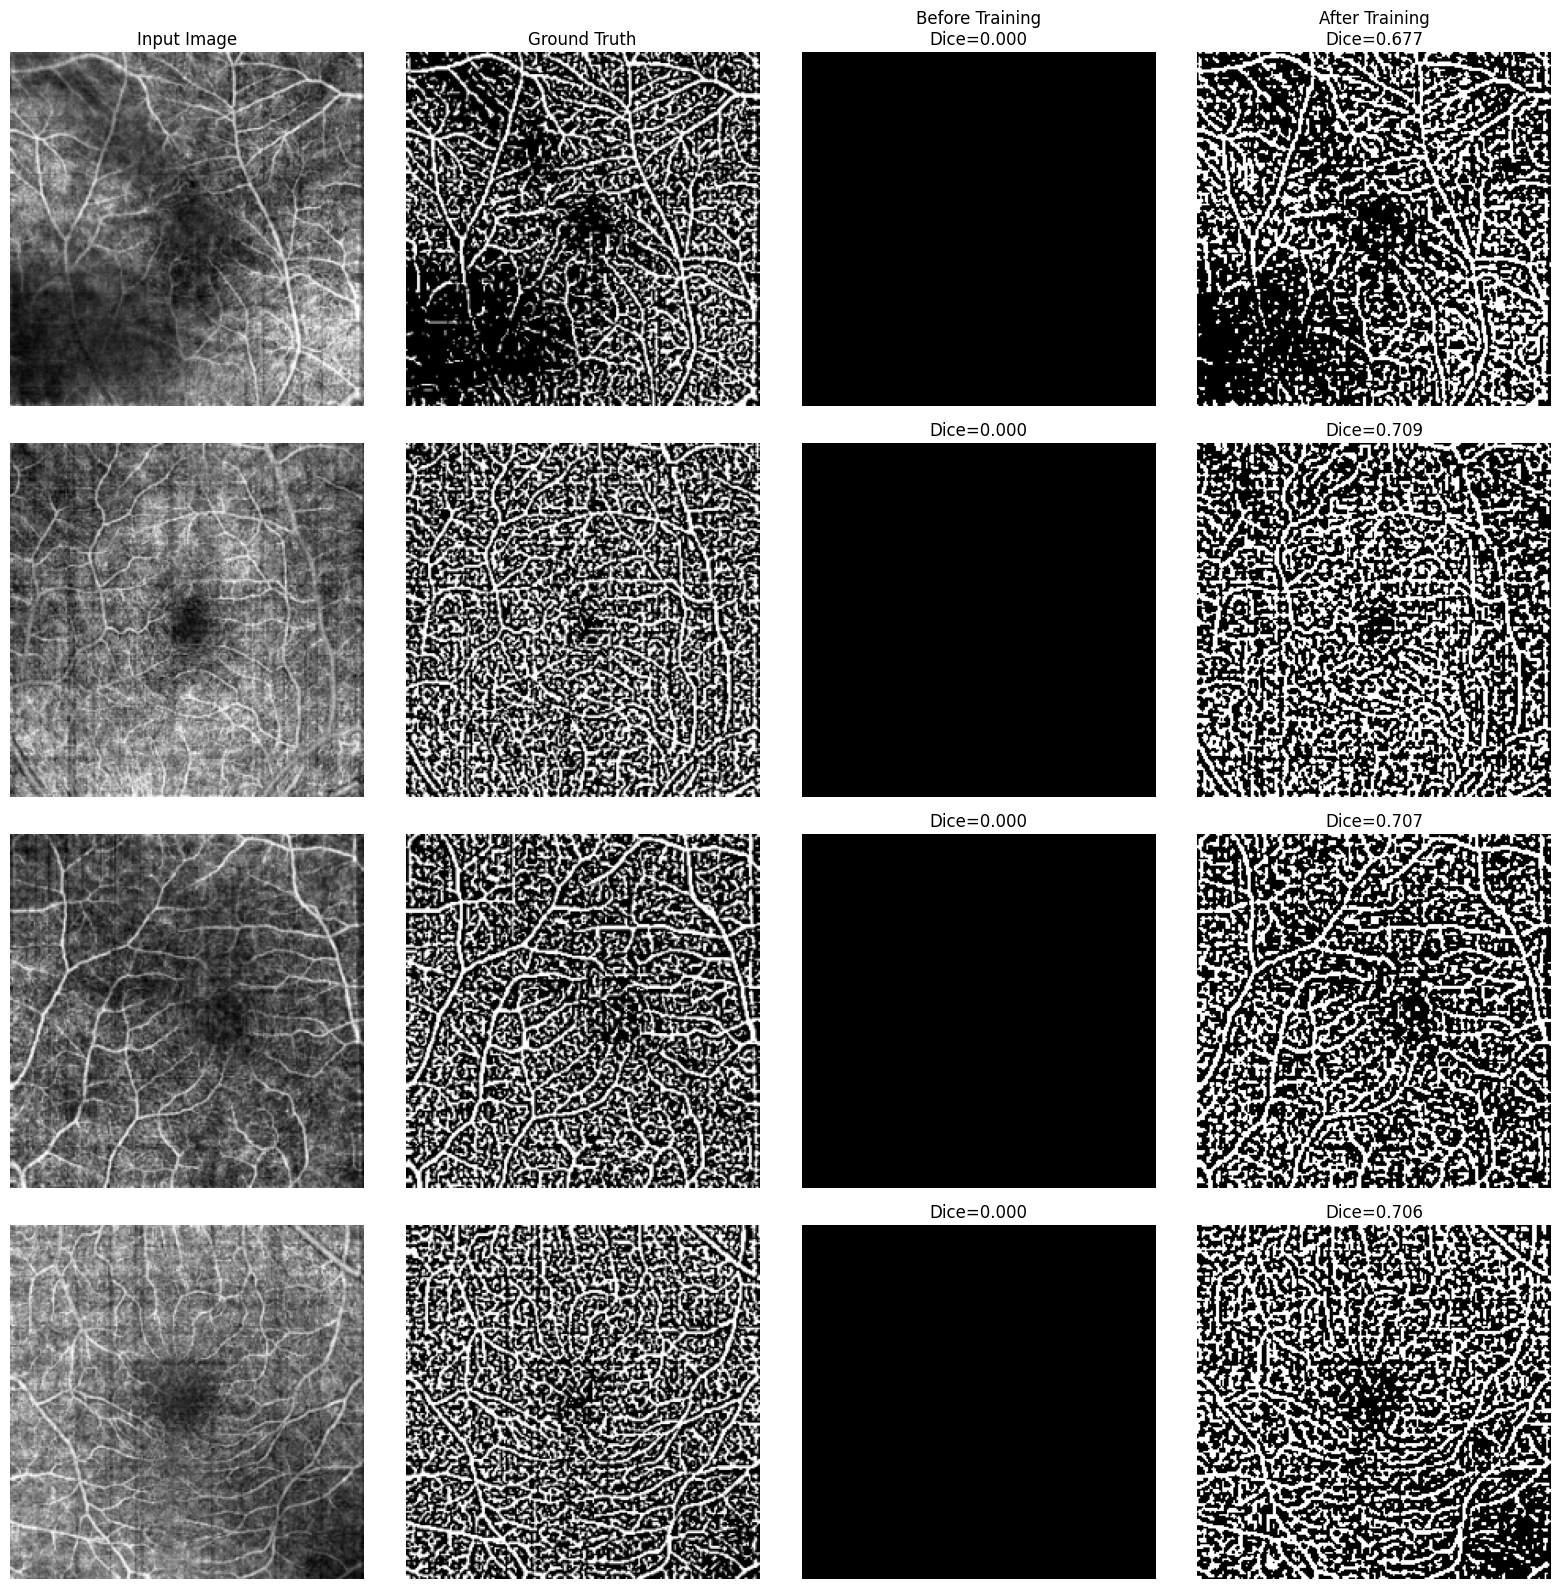


✓ Visualization complete!

What you're seeing:
  Column 1: Original OCTA images
  Column 2: Ground truth vessel masks (what we want)
  Column 3: BEFORE training (random predictions)
  Column 4: AFTER training (learned vessel patterns)

The Dice score measures overlap between prediction and ground truth:
  - Before: ~0.0-0.2 (model doesn't know vessels)
  - After: ~0.7-0.85 (model learned vessel structure!)


In [18]:


import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("SEGMENTATION COMPARISON: BEFORE vs AFTER TRAINING")
print("="*60)

# Load validation data
DATA_DIRS = ['processed_data/processed_3mm', 'processed_data/processed_6mm']
val_dataset = SegmentationDataset(DATA_DIRS, split='val')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Get 4 random samples
np.random.seed(42)
sample_indices = np.random.choice(len(val_dataset), 4, replace=False)

# Load the pretrained VAMAE model
vamae_model = VAMAE(image_size=224, patch_size=16)
vamae_model.load_state_dict(torch.load('vamae_model.pth'))
vamae_model = vamae_model.to(device)
vamae_model.eval()

# Create UNTRAINED model for comparison
untrained_model = SegmentationModel(vamae_model.encoder, freeze_encoder=False)
untrained_model = untrained_model.to(device)
untrained_model.eval()

trained_model = seg_model
trained_model.eval()

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for row, idx in enumerate(sample_indices):
    sample = val_dataset[idx]
    image = sample['image'].unsqueeze(0).to(device)
    mask_gt = sample['mask'].unsqueeze(0).to(device)

    with torch.no_grad():
        # Untrained prediction
        pred_untrained = torch.sigmoid(untrained_model(image))
        pred_untrained_binary = (pred_untrained > 0.5).float()
        dice_untrained = dice_coefficient(untrained_model(image), mask_gt)

        # Trained prediction
        pred_trained = torch.sigmoid(trained_model(image))
        pred_trained_binary = (pred_trained > 0.5).float()
        dice_trained = dice_coefficient(trained_model(image), mask_gt)

    # Column 1: Input image
    axes[row, 0].imshow(image.squeeze().cpu(), cmap='gray')
    axes[row, 0].set_title('Input Image' if row == 0 else '')
    axes[row, 0].axis('off')

    # Column 2: Ground truth
    axes[row, 1].imshow(mask_gt.squeeze().cpu(), cmap='gray')
    axes[row, 1].set_title('Ground Truth' if row == 0 else '')
    axes[row, 1].axis('off')

    # Column 3: Untrained prediction
    axes[row, 2].imshow(pred_untrained_binary.squeeze().cpu(), cmap='gray')
    axes[row, 2].set_title(f'Before Training\nDice={dice_untrained:.3f}' if row == 0 else f'Dice={dice_untrained:.3f}')
    axes[row, 2].axis('off')

    # Column 4: Trained prediction
    axes[row, 3].imshow(pred_trained_binary.squeeze().cpu(), cmap='gray')
    axes[row, 3].set_title(f'After Training\nDice={dice_trained:.3f}' if row == 0 else f'Dice={dice_trained:.3f}')
    axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig('segmentation_before_after.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete!")
print("\nWhat you're seeing:")
print("  Column 1: Original OCTA images")
print("  Column 2: Ground truth vessel masks (what we want)")
print("  Column 3: BEFORE training (random predictions)")
print("  Column 4: AFTER training (learned vessel patterns)")
print("\nThe Dice score measures overlap between prediction and ground truth:")
print("  - Before: ~0.0-0.2 (model doesn't know vessels)")
print("  - After: ~0.7-0.85 (model learned vessel structure!)")


## ImageNet Transfer Baseline Experiment

This section implements the supervised ImageNet-pretrained baseline for comparison with VAMAE.

**Steps:**
1. Install `timm` library for ImageNet models
2. Create `ImageNetViTEncoder` class that adapts RGB pretrained ViT to single-channel input
3. Initialize and save checkpoint
4. Provide loading function for downstream tasks


In [19]:
%pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
import torch.nn as nn
import timm
from transformers import ViTConfig

class ImageNetViTEncoder(nn.Module):
    """
    ImageNet-pretrained ViT encoder adapted for single-channel OCT-A images.
    Loads a supervised ImageNet ViT and replaces the patch embedding for 1-channel input.
    """
    def __init__(self, model_name='vit_base_patch16_224', image_size=224, patch_size=16):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        # Load ImageNet-pretrained ViT from timm
        print(f"Loading ImageNet-pretrained {model_name}...")
        self.vit = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,  # Remove classification head
            img_size=image_size,
        )
        
        # Get the original patch embedding dimensions
        original_embed_dim = self.vit.patch_embed.proj.weight.shape[0]  # e.g., 768
        original_in_channels = self.vit.patch_embed.proj.weight.shape[1]  # 3 for RGB
        
        # Replace patch embedding for single-channel input
        # Initialize new conv layer: copy weights from one channel and average
        new_patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=original_embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        # Initialize: average the 3 RGB channels from ImageNet pretraining
        with torch.no_grad():
            # Average across RGB channels: (1, 768, 16, 16) <- mean((3, 768, 16, 16), dim=1)
            new_patch_embed.weight.data = self.vit.patch_embed.proj.weight.data.mean(dim=1, keepdim=True)
            if self.vit.patch_embed.proj.bias is not None:
                new_patch_embed.bias.data = self.vit.patch_embed.proj.bias.data.clone()
        
        self.vit.patch_embed.proj = new_patch_embed
        
        print(f"✓ Adapted ViT for single-channel input (ImageNet weights averaged from RGB)")
        print(f"  Embed dim: {original_embed_dim}, Patches: {self.num_patches}")
    
    def forward(self, x):
        """
        Forward pass through ImageNet-pretrained ViT encoder.
        Input: (B, 1, H, W) - single channel OCT-A image
        Output: (B, num_patches+1, embed_dim) - including CLS token
        """
        return self.vit.forward_features(x)  # Returns features without classification head
    
    def get_encoder_output(self, x):
        """
        Get encoder output similar to VAMAE format (without CLS token for patch tokens).
        Returns: (B, num_patches, embed_dim) - patch embeddings only
        """
        features = self.forward(x)  # (B, num_patches+1, embed_dim)
        return features[:, 1:, :]  # Remove CLS token, return patch tokens only


In [21]:
import os

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Initialize ImageNet-pretrained ViT encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imagenet_vit = ImageNetViTEncoder(model_name='vit_base_patch16_224', image_size=224, patch_size=16)
imagenet_vit = imagenet_vit.to(device)
imagenet_vit.eval()

# Save checkpoint
checkpoint_path = 'checkpoints/imagenet_vit_base_patch16_224.pth'
torch.save({
    'model_state_dict': imagenet_vit.state_dict(),
    'model_name': 'vit_base_patch16_224',
    'image_size': 224,
    'patch_size': 16,
    'pretrained_source': 'ImageNet (supervised)',
    'adapted_for': 'single-channel OCT-A'
}, checkpoint_path)

print(f"\n✓ ImageNet-pretrained ViT checkpoint saved to: {checkpoint_path}")
print(f"  Model: ViT-Base/16, ImageNet supervised pretraining")
print(f"  Adapted for: 1-channel input (RGB weights averaged)")


Loading ImageNet-pretrained vit_base_patch16_224...
✓ Adapted ViT for single-channel input (ImageNet weights averaged from RGB)
  Embed dim: 768, Patches: 196

✓ ImageNet-pretrained ViT checkpoint saved to: checkpoints/imagenet_vit_base_patch16_224.pth
  Model: ViT-Base/16, ImageNet supervised pretraining
  Adapted for: 1-channel input (RGB weights averaged)


In [22]:
def load_imagenet_vit_checkpoint(checkpoint_path, device='cuda'):
    """Load ImageNet-pretrained ViT checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = ImageNetViTEncoder(
        model_name=checkpoint.get('model_name', 'vit_base_patch16_224'),
        image_size=checkpoint.get('image_size', 224),
        patch_size=checkpoint.get('patch_size', 16)
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    print(f"✓ Loaded checkpoint: {checkpoint.get('pretrained_source', 'ImageNet')}")
    return model

# Example usage:
# imagenet_vit = load_imagenet_vit_checkpoint('checkpoints/imagenet_vit_base_patch16_224.pth', device=device)
